In [1]:
import gymnasium as gym
import tensorflow as tf
from collections import deque
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import copy
import pandas as pd
import matplotlib 
import math
import random
import imageio

2024-06-17 17:53:57.441692: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 17:53:58.328315: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Here we use gymnasium's CartPole-v1 environment. According to the
# documentation, we have two actions in the action space, 0 (Go left)
# and 1 (Go right) 

# Also the observation space is a ndarray with shape (4,), It is as
# follows:
#   0- Cart position [-4.8,4.8]
#   1- Cart velocity [-inf,inf]
#   2- Pole angle [-.418 rad, .418 rad]
#   2- Pole anglular velocity [-inf,inf]

# Rewards: Since the goal is to keep the pole upright for as long as 
#   possible, a reward of +1 for every step taken, including the termination 
#   step, is allotted. The threshold for rewards is 475 for v1.

# Episode end: The episode ends if any one of the following occurs
#   Termination: Pole Angle is greater than ±12°
#   Termination: Cart Position is greater than ±2.4 (center of the cart reaches
#       the edge of the display)
#   Truncation: Episode length is greater than 500 (200 for v0)

# Making the environment
env = gym.make("CartPole-v1") # Use render_mode = "human" to render each episode
state, info = env.reset() # Get a sample state of the environment
stateSize = env.observation_space.shape # Number of variables to define current step
nActions = env.action_space.n # Number of actions
nObs = len(state) # Number of features

In [3]:
class ReplayMemory(object):
    """
    Implement's the replay memory algorithm.
    """
    def __init__(self, size) -> None:
        """
        Initialize the class with a double ended queue which will contain named tuples.
        """
        self.exp = deque([], maxlen=size)
        self.len = len(self.exp)
    
    def addNew(self, exp:namedtuple) -> None:
        """
        Adding a new iteration to the memory. Note thate the most recent values of
        the training will be located at the position 0 and if the list reaches maxlen
        the oldest data will be dropped.

        Args:
            exp: namedtuple: The experience should be a named tuple with keys named 
                likae this: ["state", "action", "reward", "nextState", "done"]
        """
        self.exp.appendleft(exp)
        self.len = len(self.exp)
    
    def sample(self, miniBatchSize:int) -> tuple:
        """
        Get a random number of experiences from the entire experience memory.
        The memory buffer is a double ended queue (AKA deque) of named tuples. To make 
        this list usable for tensor flow neural networks, this each named tuple inside 
        the deque has to be unpacked. we use a iterative method to unpack. It may be 
        inefficient and maybe using pandas can improve this process. one caveat of using
        pandas tables instead of deque is expensiveness of appending/deleting rows 
        (expereiances) from the table.

        Args:
            miniBatchSize: int: The size of returned the sample

        Returns:
            A tuple containing state, action, reward, nextState and done
        """

        miniBatch = random.sample(self.exp, miniBatchSize)
        state = tf.convert_to_tensor(np.array([e.state for e in miniBatch if e != None]), dtype=tf.float32)
        action = tf.convert_to_tensor(np.array([e.action for e in miniBatch if e != None]), dtype=tf.float32)
        reward = tf.convert_to_tensor(np.array([e.reward for e in miniBatch if e != None]), dtype=tf.float32)
        nextState = tf.convert_to_tensor(np.array([e.nextState for e in miniBatch if e != None]), dtype=tf.float32)
        done = tf.convert_to_tensor(np.array([e.done for e in miniBatch if e != None]).astype(np.uint8), dtype=tf.float32)

        return tuple((state, action, reward, nextState, done))

def decayEbsilon(currE: float, rate:float, minE:float) -> float:
    """
    Decreases ebsilon each time called. It multiplies current ebsilon to decrease rate.
    The decreasing is continued untill reaching minE.
    """
    return(max(currE*rate, minE))

def computeLoss(experiences:tuple, gamma:float, qNetwork, target_qNetwork): #chkd
    """
    Computes the loss betweeen y targets and Q values. If the reward of current step is R_i,
    then y = R_i if the episode is terminated, if not, y = R_i + gamma * Q_hat(i+1) where gamma
    is the discount factor and Q_hat is the predicted return of the step i+1 with the target_qNetwork.
    
    Args:
        experiences: Tuple: A tuple containing experiences as tensorflow tensors.
        gamma: float: The discount factor.
        qNetwork: tensorflow NN: The neural network for predicting the Q.
        target_qNetwork: tensorflow NN: The neural network for predicting the target-Q.
    
    Returns:
        loss: float: The Mean squared errors (AKA. MSE) of the Qs.
    """

    # Unpack the experience mini-batch
    state, action, reward, nextState, done = experiences

    # To implement the calculation scheme explained in comments, we multiply Qhat bu (1-done).
    # If the episode has termiated done == True so (1-done) = 0.
    Qhat = tf.reduce_max(target_qNetwork(nextState), axis=-1)
    yTarget = reward + gamma *  Qhat*((1 - done))
    
    qValues = qNetwork(state)
    qValues = tf.gather_nd(qValues, tf.stack([tf.range(qValues.shape[0]), tf.cast(action, tf.int32)], axis=1))
    loss = tf.keras.losses.MSE(yTarget, qValues)
    
    return loss

def softUpdateNetwork(qNetwork, target_qNetwork, Tau: float):
    """
    Update the target_qNetwork's weights using soft update, This helps the target network to avoid
    changing very repidly as qNetwork is updated. This increases the learning srtability greatly.
    The formulation is as follows:
        W_targetNetwork = W_targetNetwork * (1 - Tau) + Tau * W_qetwork

    Args:
        qNetwork, target_qNetwork: Tensorflow networks: Self explainatory.
        Tau: float: The soft update parameter, Tau << 1
    """
    # Because we use tf.function in this project, we cant use get_waight() or set_weight() functions
    # to update the model weights. This is due to the fact that the previouse functions use numpy
    # in their structures which is not supported while generating tensorflow graphs. So we for updating 
    # the weights, we have to iterate throught each and every one and replace them in a loop which is not
    # ideal (performance-wise). Below is a way to update the weights in batches but can only be used 
    # if we are doing the calculations in eagar mode.

    # W_target = np.array(target_qNetwork.get_weights(), dtype=object)
    # w_qNetwork = np.array(qNetwork.get_weights(), dtype=object)
    # W_target = (1-Tau) * W_target + Tau * w_qNetwork
    # target_qNetwork.set_weights(W_target)

    for target_weights, q_net_weights in zip(target_qNetwork.weights, qNetwork.weights):
        target_weights.assign(Tau * q_net_weights + (1.0 - Tau) * target_weights)


@tf.function()
def fitQNetworks(experience, gamma, qNetwork, target_qNetwork, optimizer):
    """
    Updates the weights of the neural networks with a custom training loop. The target network is
    updated my a soft update mechanism.

    Args: 
        experience: tuple: The data for training networks. This data has to be passed with 
            replayMemory.sample() function which returns a tuple of tensorflow tensors in 
            the following order: state, action, reward, nextState, done)
        gamma: flaot: The learning rate.
        qNetwork, target_qNetwork: tensorflow NNs
        optimizer: tf.keras.optimizers.Adam: The optimizer for updating the networks.
    
    Returns:
        None
    """
    with tf.GradientTape() as tape:
        loss = computeLoss(experience, gamma, qNetwork, target_qNetwork)

    grad = tape.gradient(loss, qNetwork.trainable_variables)
    optimizer.apply_gradients(zip(grad, qNetwork.trainable_variables))
    softUpdateNetwork(qNetwork, target_qNetwork, .001)


def getAction(qVal: list, e:float) -> int:
    """
    Gets the action via an ebsilon-greedy algoithm. This entire action state is [0, 1, 2, 3].
    With a probability of ebsilon, a random choice will be picked, else the action with
    the greatest Q value will be pucked

    Args:
        qVal: list: The q value of actions
        e: float: The ebsilon which represents the probability of a random action
    
    Returns:
        action_: int: 0 for doing nothing, and 1 for left thruster, 2 form main thruster
            and 3 for right thruster.
    """
    rnd = random.random()

    # The actions possble for cartPole i.e. [One step to left, One step to right]
    actions = [0, 1] 

    if rnd < e:
        # Take a random step
        action_ = random.randint(0,1)
    else:
        action_ = actions[np.argmax(qVal)]
    
    return action_

def updateNetworks(timeStep: int, replayMem: ReplayMemory, miniBatchSize: int, C: int) -> bool:
    """
    Determines if the neural network (qNetwork and tqrget_qNetwork) weights are to be updated.
    The update happens C time steps apart. for performance reasons.

    Args:
        timeStep: int: The time step of the current episode
        replayMem: deque: A double edged queue containing the experperiences as named tuples.
            the named tuples should be as follows: ["state", "action", "reward", "nextState", "done"]

    Returns:
        A boolean, True for update and False to not update.
    """

    return True if ((timeStep+1) % C == 0 and miniBatchSize < replayMem.len) else False

def getEbsilon(e:float, eDecay:float, minE: float) -> float:
    """
    Decay ebsilon for ebsilon-Greedy algorithm. Ebsilon starts with 1 at the beginning of the 
    learning process which indicates that the agent completely acts on a random basis (AKA 
    Exploration) but as the learning is continued, the rate at which agent acts randomly decreased
    via multiplying the ebsilon by a decay rate which ensures agent acting based on it's learnings
    (AKA Exploitation).

    Args:
        e: float: The current rate of ebsilon
        eDecay: float: The decay rate of ebsilon
        minE: float: the minimum amount of ebsilon. To ensure the exploration possibility of the 
            agent, ebsilon shuldn't be less than a certain amount.

    Returns: ebsilon's value
    """

    return max(minE, eDecay * e)

def renderEpisode(initialState: int, actions:str, envName:str, delay:float = .02) -> None:
    """
    Renders the previousely done episode so the user can see what happened. We use gymanium to 
    render the environment. All the render is done in the "human" mode.

    Args:
        initialState: int: The initial seed that determine's the initial state of the episode 
            (The state before we took teh first action)
        actions: string: A string of actions delimited by comma (i.e. 1,2,3,1,3, etc.)
        env: string: The name of the environment to render the actions, It has to be a gymnasium
            compatible environmnet.
        delay: int: The delay (In seconds) to put between showing each step to make it more 
            comprehensive.
    
    Returns: None
    """
    tempEnv = gym.make(envName, render_mode = "human") # Use render_mode = "human" to render each episode
    state, info = tempEnv.reset(seed=initialState) # Get a sample state of the environment

    # Process the string of actions taken
    actions = actions.split(",") # Split the data
    actions = actions[:-1] # Remove the lat Null member of the list
    actions = list(map(int, actions)) # Convert the strings to ints

    # Take steps
    for action in actions:
        _, _, terminated, truncated, _ = tempEnv.step(action)
    
        # Exit loop if the simulation has ended
        if terminated or truncated:
            _, _ = tempEnv.reset()
            break
        
        # Delay showing the next step
        time.sleep(delay)

    tempEnv.close()
    
def testAgent(envName:str, network, saveVideoName:str = "") -> int:
    """
    Runs an agent through a predefined gymnasium environment. The actions of the agent are chosen via
    a greedy policy by a trained neural network. To see the agent in action, the environment's render
    mode has to be "human" or  "rgb-array"

    Args:   
        envName: string: The name of the environment.
        network: tensorflow NN: The trained neural network that accepts state as an input and outputs
            the desired action.
        environment: gymnasium env: The environment for testing.
        saveVideoName:string: The name of the file to be saved. If equals "", No video file will be 
            saved; Also remember that the file name should include the file extension.
    """
    
    def interactionLoop(env_, seed_, V_):    
        """
        The loop that lets agent interact with the environment.
        if V_ == True, save the video (requires render_mdeo == rgb_array)
        """
        state, _ = env_.reset(seed = seed_)
        points = 0
        if V_:
            videoWriter = imageio.get_writer(saveVideoName, fps = 30)

        maxStepN = 1000
        for t in range(maxStepN):
            # Take greedy steps
            action = np.argmax(network(np.expand_dims(state, axis = 0)))

            state, reward, terminated, truncated, _ = env_.step(action)

            if V_:
                videoWriter.append_data(env_.render())

            points += reward

            # Exit loop if the simulation has ended
            if terminated or truncated:
                _, _ = env_.reset()

                if V_:
                    videoWriter.close()
                    
                return points
    
    # Get the random seed to get the initial state of the agent.
    seed = random.randint(0, 1_000_000_000)
    
    # Because gymnasium doesn't let the environment to have two render modes, 
    # we run the simulation twice, The first renders the environment with "human"
    # mdoe and the secon run, runs the environment with "egb_array" mode that 
    # lets us save the interaction process to a video file. Both loops are run 
    # with the same seeds and neural networks so they should have identical outputs.
    # environment = gym.make(envName, render_mode = "human")
    # point = interactionLoop(environment, seed, False)
            
    environment = gym.make(envName, render_mode = "rgb_array")
    point = interactionLoop(environment, seed, True)

    return point

def analyzeLearning(episodePointHistory:list, episodeTimeHistory:list) -> None:
    """
    Plots the learning performance of the agent

    Args:
        episodePointHistory: list: The commulative rewards of each episode in consrcutive time steps.
        episodeTimeHistory: list: The time it took to run the episode
    """
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(episodePointHistory)
    ax1.set_title("Episode points")

    ax2.plot(episodeTimeHistory)
    ax2.set_title("Episode elapsed time")

In [4]:
# Making the neural networks
# Specifying the optimizer.
optimizer = tf.keras.optimizers.Adam(.001)

# Because of the binary structure of the actions possible (Step to right or left) we have
# added a taken a sigmoid activation for the output layer.

# The q-Network
inputs = tf.keras.layers.Input(shape=stateSize)
l1 = tf.keras.layers.Dense(units=64, activation="relu", name = "L1")(inputs)
l2 = tf.keras.layers.Dense(units=64, activation="relu", name = "L2")(l1)
output = tf.keras.layers.Dense(units=nActions, activation="linear", name = "out")(l2)
qNetwork = tf.keras.Model(inputs = inputs, outputs = output, name = "q-network")

# The Target q-Network
target_inputs = tf.keras.layers.Input(shape=stateSize)
target_l1 = tf.keras.layers.Dense(units=64, activation="relu", name = "L1")(target_inputs)
target_l2 = tf.keras.layers.Dense(units=64, activation="relu", name = "L2")(target_l1)
target_output = tf.keras.layers.Dense(units=nActions, activation="linear", name = "out")(target_l2)
target_qNetwork = tf.keras.Model(inputs = target_inputs, outputs = target_output, name = "target-q-network")

# Both qnetwork and target-qnetworks's weights are initialized but at the ebginning
# the two networks should have the same weights.
target_qNetwork.set_weights(qNetwork.get_weights())

2024-06-17 17:53:59.877338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-17 17:53:59.907352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-17 17:53:59.907593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
# Start the timer
tstart = time.time()

# The experience of the agent is saved as a named tuple containing various variables
agentExp = namedtuple("exp", ["state", "action", "reward", "nextState", "done"])

# Parameters
nEpisodes = 5000 # Number of learning episodes
maxNumTimeSteps = 2000 # The number of time step in each episode
gamma = .995 # The discount factor
ebsilon = 1 # The starting  value of epsilon
ebsilonEnd   = .1 # The finishing value of epsilon
eDecay = 0.995 # The rate at which epsilon decays 
miniBatchSize = 400 # The length of minibatch that is used for training
memorySize = 1_000_000 # The length of the entire memory
numUpdateTS = 4 # Frequency of timesteps to update the NNs
numP_Average = 100 # The number of previous episodes for calculating the average episode reward

# Variables for saving the required data for later analysis
episodePointHist = [] # For saving each episode's point for later demonstration
episodeTimeHist = [] # For saving the time it took for episode to end
actionString = "" # A string containing consecutive actions taken in an episode (delimited by comma, i.e. 1,2,4,2,1 etc.)
episodeHistDf = pd.DataFrame(columns=["episode", "actions", "seed", "points"])
initialCond = None # initial condition (state) of the episode

# Making the memory buffer object
mem = ReplayMemory(size=memorySize)

for episode in range(nEpisodes):
    initialSeed = random.randint(1,1_000_000_000) # The random seed that determines the episode's I.C.
    state, info = env.reset(seed = initialSeed)
    points = 0
    actionString = ""
    initialCond = state
    
    tempTime = time.time()
    for t in range(maxNumTimeSteps):

        # We use teh __call__ function instead of predict() method because the predict() 
        # function is better suited (faster) for batches of data but we here only have 
        # a single state to predict.
        qValueForActions = qNetwork(np.expand_dims(state, axis = 0))

        # use ebsilon-Greedy algorithm to take the new step
        action = getAction(qValueForActions, ebsilon)

        # Take a step
        observation, reward, terminated, truncated, info = env.step(action)
        
        # Store the experience of the current step in an experience deque.
        mem.addNew(
            agentExp(
                state, # Current state
                action, 
                reward, # Current state's reward
                observation, # Next state
                True if terminated or truncated else False
            )
        )
        env.render()
        # Check to see if we have to update the networks in the current step
        update = updateNetworks(t, mem, miniBatchSize, numUpdateTS)

        if update:
            # Update the NNs
            experience = mem.sample(miniBatchSize)
            fitQNetworks(experience, gamma, qNetwork, target_qNetwork, optimizer)

        # Save the necessary data
        points += reward
        state = observation.copy()
        actionString += f"{action},"

        if terminated or truncated:
            # Save the episode histry in dataframe
            if (episode+1)%10 == 0:
                # only save every 10 episodes
                episodeHistDf = pd.concat([episodeHistDf, pd.DataFrame({
                    "episode": [episode], 
                    "actions": [actionString], 
                    "seed": [initialSeed], 
                    "points": [points]
                })])

            break
    
    # Saving the current episode's points and time
    episodePointHist.append(points)
    episodeTimeHist.append(time.time()-tempTime)

    # Getting the average of {numP_Average} episodes
    epPointAvg = np.mean(episodePointHist[-numP_Average:])

    # Decay ebsilon
    ebsilon = decayEbsilon(ebsilon, eDecay, ebsilonEnd)
    
    print(f"\rElapsedTime: {(time.time() - tstart):.0f}s | Episode: {episode} | The average of the {numP_Average} episodes is: {epPointAvg:.2f}", end = " ")

    if 200 < epPointAvg:
        Tend = time.time()
        print(f"\nThe learning ended. Elapsed time for learning: {Tend-tstart}s")
        break

# Reset the index
episodeHistDf.reset_index(drop=True, inplace=True)

env.close()

2024-06-17 17:54:00.146309: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:190] failed to create cublas handle: the resource allocation failed
2024-06-17 17:54:00.146441: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:193] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2024-06-17 17:54:00.146469: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at matmul_op_impl.h:627 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support


InternalError: Exception encountered when calling layer 'L1' (type Dense).

{{function_node __wrapped__MatMul_device_/job:localhost/replica:0/task:0/device:GPU:0}} Attempting to perform BLAS operation using StreamExecutor without BLAS support [Op:MatMul] name: 

Call arguments received by layer 'L1' (type Dense):
  • inputs=tf.Tensor(shape=(1, 4), dtype=float32)

In [ ]:
testAgent("CartPole-v1", qNetwork, "data/cartPole-200.gif")

212.0

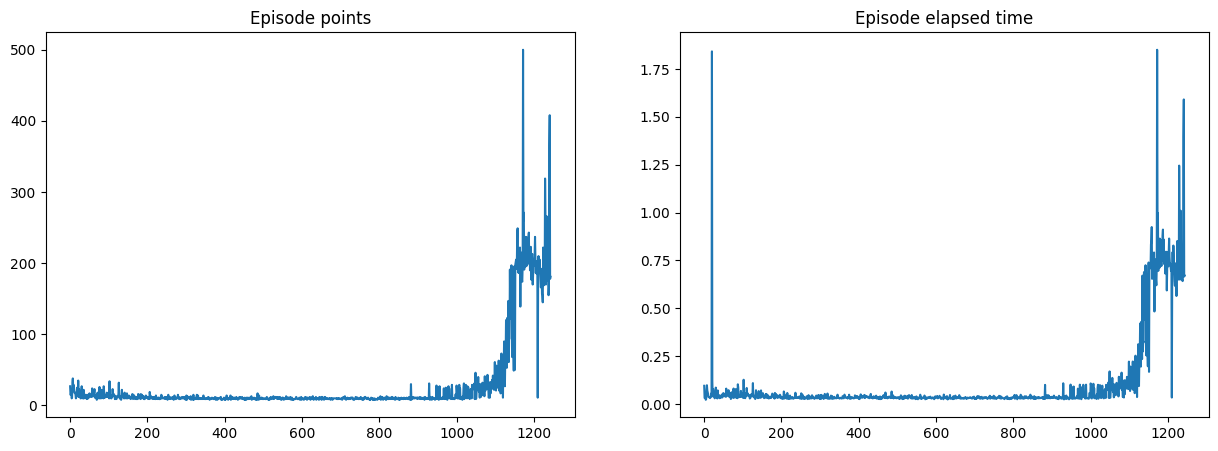

In [ ]:
analyzeLearning(episodePointHist, episodeTimeHist)

In [ ]:
renderEpisode(
    episodeHistDf.iloc[169].seed,
    episodeHistDf.iloc[169].actions,
    "CartPole-v1"
)